# seagliderOG1 demo

The purpose of this notebook is to demonstrate the functionality of `seagliderOG1` to convert from Seaglider basestation files to OG1 format.

- OG1 format is a newly agreed format (since June 2024) for glider data sets from various platforms (e.g., Seaglider, Slocum, Seaexplorer).  It lives on github here: (https://github.com/OceanGlidersCommunity/OG-format-user-manual).
- OG1 manual: https://oceangliderscommunity.github.io/OG-format-user-manual/OG_Format.html

The test case is to convert sg015 data from the Labrador Sea in September 2004.

The demo is organised to show

- Conversion of a single dive cycle (single `p*.nc` file)

- Conversion for a folder of local dive-cycle files (full mission of `p*.nc` files)

- Download from remote server + conversion (directory with full mission of `p*.nc` files)

Options are provided to only load e.g. 10 files, but note that OG1 format expects a full mission.


In [1]:
import pathlib
import sys

script_dir = pathlib.Path().parent.absolute()
parent_dir = script_dir.parents[0]
sys.path.append(str(parent_dir))
sys.path.append(str(parent_dir) + '/seagliderOG1')
print(parent_dir)
print(sys.path)

import xarray as xr
import os
import pooch
from seagliderOG1 import readers, writers, plotters, tools
from seagliderOG1 import convertOG1, vocabularies


/home/runner/work/seagliderOG1/seagliderOG1
['/home/runner/micromamba/envs/TEST/lib/python312.zip', '/home/runner/micromamba/envs/TEST/lib/python3.12', '/home/runner/micromamba/envs/TEST/lib/python3.12/lib-dynload', '', '/home/runner/micromamba/envs/TEST/lib/python3.12/site-packages', '/home/runner/work/seagliderOG1/seagliderOG1', '/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1']


/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:472: SyntaxWarning: invalid escape sequence '\d'
  fill_val = 2 ** (int(re.findall("\d+", str(new_dtype))[0]) - 1) - 1


In [2]:
# Specify the path for writing datafiles
data_path = os.path.join(parent_dir, 'data')

## Reading basestation files

This has three ways to load a glider dataset.

Load an example dataset using `seagliderOG1.fetchers.load_sample_dataset`

Alternatively, use your own with e.g. `ds = xr.open_dataset('/path/to/yourfile.nc')`

### Load single sample dataset

In [3]:
ds = readers.load_sample_dataset()
ds

HTTPError: 404 Client Error: Not Found for url: https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/p0040034_20031007.nc

### Load datasets from a local directory

In [4]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
list_datasets = readers.read_basestation(input_dir, start_profile=500, end_profile=503)

# Where list_datasets is a list of xarray datasets.  A single dataset can be accessed as
ds = list_datasets[0]

ValueError: Source must be a valid URL or directory path.

In [5]:
ds

NameError: name 'ds' is not defined

### Load datasets from a remote directory (URL)

In [6]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
list_datasets = readers.read_basestation(server, start_profile=500, end_profile=503)

## Convert to OG1 format

Process:

1. For one basestation dataset, split the dataset by dimension (`split_ds`)
3. Transform into OG1 format: dataset with dims `sg_data_point`
    - Change the dimension to `N_MEASUREMENTS`
    - Rename variables according to `vocabularies.standard_names` 
    - Assign variable attributes according to `vocabularies.vocab_attrs`.  (Note: This *could* go wrong since it makes assumptions about the input variables. May need additional handling.)
4. Add missing mandatory variables: 
    - From `split_ds[(gps_info,)]`, add the `LATITUDE_GPS`, `LONGITUDE_GPS` and `TIME_GPS` (Note: presently `TIME_GPS` is stripped before saving, but `TIME` values contain `TIME_GPS`)
    - Create `PROFILE_NUMBER` and `PHASE`
    - Calculate `DEPTH_Z` which is positive up
5. Update attributes for the file. 
    - Combines `creator` and `contributor` from original attributes into `contributor`
    - Adds `contributing_institutions` based on `institution`
    - Reformats time in `time_coverage_*` and `start_time`--> `start_date`
    - Adds `date_modified`
    - Renames `comments`-->`history`, `site`-->`summary`
    - Adds `title`, `platform`, `platform_vocabulary`, `featureType`, `Conventions`, `rtqc_method*` according to OceanGliders format
    - Retains `naming_authority`, `institution`, `project`, `geospatial_*` as OG attributes
    - Retains extra attributes: `license`, `keywords`, `keywords_vocabulary`, `file_version`, `acknowledgement`, `date_created`, `disclaimer`

Future behaviour to be added:

6. Retain the variables starting with `sg_cal` and check whether they vary over the mission (shouldn't)
6. Add sensors, using information in the `split_ds` with no dimensions
    - Need (from sg_cal_constants: `sg_cal` plus `volmax`, `vbd_cnts_per_cc`, `therm_expan`, `t_*`, `mass`, `hd_*`, `ctcor`, `cpcor`, `c_*`, `abs_compress`, `a`, `Tcor`, `Soc`, `Pcor`, `Foffset`)
    - Maybe also `reviewed`, `magnetic_variation` (which will change with position), `log_D_FLARE`, `flight_avg_speed_north` and `flight_avg_speed_east` also with `_gsm`, `depth_avg_curr_north` and `depth_avg_curr_east` also with `_gsm`, 
    `wlbb2f` - means sensor
    `sg_cal_mission_title`
    `sg_cal_id_str`
    `calibcomm_oxygen`
    `calibcomm`
    `sbe41` means ??
    `hdm_qc`
    `glider`
    
### Convert a single (sample) dataset

In [7]:
# Loads one dataset (p0150500_20050213.nc)
ds = readers.load_sample_dataset()

ds_OG1 = convertOG1.convert_to_OG1(ds)

# Check the results - uncomment the following lines to either generate a plot or show the variables.
plotters.plot_profile_depth(ds_OG1)

HTTPError: 404 Client Error: Not Found for url: https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/p0040034_20031007.nc

In [8]:
# Print to screen a table of the variables and variable attributes
#plotters.show_attributes(ds_OG1)
ds_OG1

NameError: name 'ds_OG1' is not defined

### Convert mission from a local directory of basestation files

- For local data in the directory `input_dir`
- Creates a plot of ctd_depth against ctd_time.


In [9]:
# Specify the input directory on your local machine
input_dir = "/Users/eddifying/Dropbox/data/sg015-ncei-download"

# Load and concatenate all datasets in the input directory
# Optionally, specify the range of profiles to load (start_profile, end_profile)
list_datasets = readers.read_basestation(input_dir, start_profile=500, end_profile=503)

# Convert the list of datasets to OG1
ds_OG1 = convertOG1.convert_to_OG1(list_datasets)

# Generate a simple plot
plotters.plot_profile_depth(ds_OG1)
#plotters.show_contents(ds_all,'attrs')

ValueError: Source must be a valid URL or directory path.

### Convert mission from the NCEI server (with p*nc files)

- Data from the sg015 mission in the Labrador Sea (https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:0111844), dataset identifier gov.noaa.nodc:0111844.


In [10]:
# Specify the server where data are located
server = "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/"

# Load and concatenate all datasets from the server, optionally specifying the range of profiles to load
list_datasets = readers.read_basestation(server, start_profile=500, end_profile=503)

# Convert the list of datasets to OG1
ds_OG1 = convertOG1.convert_to_OG1(list_datasets)

Variable 'vert_speed_gsm' not in OG1 vocabulary.


Variable 'time' not in OG1 vocabulary.


Variable 'speed_gsm' not in OG1 vocabulary.


Variable 'sound_velocity' not in OG1 vocabulary.


Variable 'north_displacement_gsm' not in OG1 vocabulary.


Variable 'longitude_gsm' not in OG1 vocabulary.


Variable 'latitude_gsm' not in OG1 vocabulary.


Variable 'horz_speed_gsm' not in OG1 vocabulary.


Variable 'glide_angle_gsm' not in OG1 vocabulary.


Variable 'eng_wlbb2f_VFtemp' not in OG1 vocabulary.


Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.


Variable 'eng_sbect_condFreq' not in OG1 vocabulary.


Variable 'eng_elaps_t_0000' not in OG1 vocabulary.


Variable 'eng_elaps_t' not in OG1 vocabulary.


Variable 'eng_depth' not in OG1 vocabulary.


Variable 'east_displacement_gsm' not in OG1 vocabulary.


Variable 'depth' not in OG1 vocabulary.


Variable 'density' not in OG1 vocabulary.


Variable 'buoyancy' not in OG1 vocabulary.


/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:359: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return ds.assign(divenum=('N_MEASUREMENTS', [dive_number] * ds.dims['N_MEASUREMENTS']))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:178: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['dive_num_cast'] = (['N_MEASUREMENTS'], np.full(ds.dims['N_MEASUREMENTS'], np.nan))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:239: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in or

No conversion information found for cm s-1 to degrees
No conversion information found for micromoles/kg to percent
wlbb2f
Adding sensor: SENSOR_FLUOROMETERS
sbe41
sbe41
SBE t12/c12 calibration 30DEC03
30DEC03
Unknown


Variable 'vert_speed_gsm' not in OG1 vocabulary.


Variable 'time' not in OG1 vocabulary.


Variable 'speed_gsm' not in OG1 vocabulary.


Variable 'sound_velocity' not in OG1 vocabulary.


Variable 'north_displacement_gsm' not in OG1 vocabulary.


Variable 'longitude_gsm' not in OG1 vocabulary.


Variable 'latitude_gsm' not in OG1 vocabulary.


Variable 'horz_speed_gsm' not in OG1 vocabulary.


Variable 'glide_angle_gsm' not in OG1 vocabulary.


Variable 'eng_wlbb2f_VFtemp' not in OG1 vocabulary.


Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.


Variable 'eng_sbect_condFreq' not in OG1 vocabulary.


Variable 'eng_elaps_t_0000' not in OG1 vocabulary.


Variable 'eng_elaps_t' not in OG1 vocabulary.


Variable 'eng_depth' not in OG1 vocabulary.


Variable 'east_displacement_gsm' not in OG1 vocabulary.


Variable 'depth' not in OG1 vocabulary.


Variable 'density' not in OG1 vocabulary.


Variable 'buoyancy' not in OG1 vocabulary.


/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:359: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return ds.assign(divenum=('N_MEASUREMENTS', [dive_number] * ds.dims['N_MEASUREMENTS']))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:178: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['dive_num_cast'] = (['N_MEASUREMENTS'], np.full(ds.dims['N_MEASUREMENTS'], np.nan))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:239: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in or

No conversion information found for cm s-1 to degrees
No conversion information found for micromoles/kg to percent
wlbb2f
Adding sensor: SENSOR_FLUOROMETERS
sbe41
sbe41
SBE t12/c12 calibration 30DEC03
30DEC03
Unknown


Variable 'vert_speed_gsm' not in OG1 vocabulary.


Variable 'time' not in OG1 vocabulary.


Variable 'speed_gsm' not in OG1 vocabulary.


Variable 'sound_velocity' not in OG1 vocabulary.


Variable 'north_displacement_gsm' not in OG1 vocabulary.


Variable 'longitude_gsm' not in OG1 vocabulary.


Variable 'latitude_gsm' not in OG1 vocabulary.


Variable 'horz_speed_gsm' not in OG1 vocabulary.


Variable 'glide_angle_gsm' not in OG1 vocabulary.


Variable 'eng_wlbb2f_VFtemp' not in OG1 vocabulary.


Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.


Variable 'eng_sbect_condFreq' not in OG1 vocabulary.


Variable 'eng_elaps_t_0000' not in OG1 vocabulary.


Variable 'eng_elaps_t' not in OG1 vocabulary.


Variable 'eng_depth' not in OG1 vocabulary.


Variable 'east_displacement_gsm' not in OG1 vocabulary.


Variable 'depth' not in OG1 vocabulary.


Variable 'density' not in OG1 vocabulary.


Variable 'buoyancy' not in OG1 vocabulary.


/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:359: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return ds.assign(divenum=('N_MEASUREMENTS', [dive_number] * ds.dims['N_MEASUREMENTS']))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:178: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['dive_num_cast'] = (['N_MEASUREMENTS'], np.full(ds.dims['N_MEASUREMENTS'], np.nan))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:239: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in or

No conversion information found for cm s-1 to degrees
No conversion information found for micromoles/kg to percent
wlbb2f
Adding sensor: SENSOR_FLUOROMETERS
sbe41
sbe41
SBE t12/c12 calibration 30DEC03
30DEC03
Unknown


Variable 'vert_speed_gsm' not in OG1 vocabulary.


Variable 'time' not in OG1 vocabulary.


Variable 'speed_gsm' not in OG1 vocabulary.


Variable 'sound_velocity' not in OG1 vocabulary.


Variable 'north_displacement_gsm' not in OG1 vocabulary.


Variable 'longitude_gsm' not in OG1 vocabulary.


Variable 'latitude_gsm' not in OG1 vocabulary.


Variable 'horz_speed_gsm' not in OG1 vocabulary.


Variable 'glide_angle_gsm' not in OG1 vocabulary.


Variable 'eng_wlbb2f_VFtemp' not in OG1 vocabulary.


Variable 'eng_sbect_tempFreq' not in OG1 vocabulary.


Variable 'eng_sbect_condFreq' not in OG1 vocabulary.


Variable 'eng_elaps_t_0000' not in OG1 vocabulary.


Variable 'eng_elaps_t' not in OG1 vocabulary.


Variable 'eng_depth' not in OG1 vocabulary.


Variable 'east_displacement_gsm' not in OG1 vocabulary.


Variable 'depth' not in OG1 vocabulary.


Variable 'density' not in OG1 vocabulary.


Variable 'buoyancy' not in OG1 vocabulary.


No conversion information found for cm s-1 to degrees
No conversion information found for micromoles/kg to percent
wlbb2f
Adding sensor: SENSOR_FLUOROMETERS
sbe41
sbe41
SBE t12/c12 calibration 30DEC03
30DEC03
Unknown


/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:359: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return ds.assign(divenum=('N_MEASUREMENTS', [dive_number] * ds.dims['N_MEASUREMENTS']))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:178: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  ds['dive_num_cast'] = (['N_MEASUREMENTS'], np.full(ds.dims['N_MEASUREMENTS'], np.nan))
/home/runner/work/seagliderOG1/seagliderOG1/seagliderOG1/tools.py:239: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in or

## Saving data

Due to problems with writing `xarray` datasets as netCDF when attributes are not of a specified type (`str`, `Number`, `np.ndarray`, `np.number`, `list`, `tuple`), a function was written `save_dataset`.

In [11]:
# Write the file
# This writer catches errors in data types (DType errors) when using xr.to_netcdf()
# The solution is to convert them to strings, which may be undesired behaviour
output_file = os.path.join(data_path, 'demo_test.nc')
if os.path.exists(output_file):
    os.remove(output_file) 

writers.save_dataset(ds_OG1, output_file);

TypeError Invalid value for attr 'calibration_parameters': {'t_g': 0.00431040083, 't_h': 0.000631750336, 't_i': 2.27137914e-05, 't_j': 2.20168797e-06, 'c_g': -10.2690994, 'c_h': 1.1547191, 'c_i': -0.00143967206, 'c_j': 0.000204972837, 'cpcor': -9.57e-08, 'ctcor': 3.25e-06}. For serialization to netCDF files, its value must be of one of the following types: str, Number, ndarray, number, list, tuple, bytes
variable 'SENSOR_CTD_UNKNOWN': Converting attribute 'calibration_parameters' with value '{'t_g': 0.00431040083, 't_h': 0.000631750336, 't_i': 2.27137914e-05, 't_j': 2.20168797e-06, 'c_g': -10.2690994, 'c_h': 1.1547191, 'c_i': -0.00143967206, 'c_j': 0.000204972837, 'cpcor': -9.57e-08, 'ctcor': 3.25e-06}' to string.


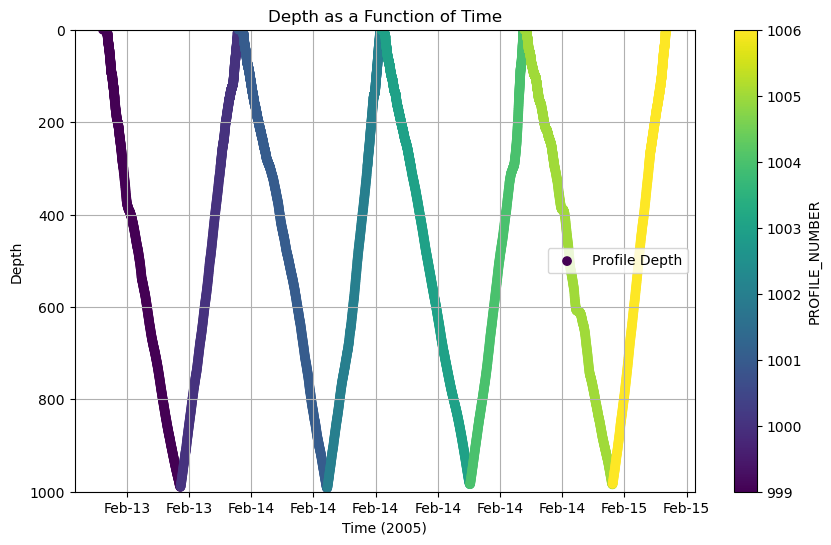

In [12]:
# Load the data saved
ds1 = xr.open_dataset(output_file)

# Generate a simple plot
#plotters.show_contents(ds_all,'attrs')
plotters.plot_depth_colored(ds1, color_by='PROFILE_NUMBER')


## Run multiple missions

In [13]:
# Add these to existing attributes - update to your details
contrib_to_append = vocabularies.contrib_to_append
print(contrib_to_append)

{'contributor_name': 'Eleanor Frajka-Williams', 'contributor_email': 'eleanorfrajka@gmail.com', 'contributor_role': 'Data scientist', 'contributor_role_vocabulary': 'http://vocab.nerc.ac.uk/search_nvs/W08', 'contributing_institutions': 'University of Hamburg - Institute of Oceanography', 'contributing_institutions_vocabulary': 'https://edmo.seadatanet.org/report/1156', 'contributing_institutions_role': 'Data scientist', 'contributing_institutions_role_vocabulary': 'http://vocab.nerc.ac.uk/search_nvs/W08'}


In [14]:
# Specify a list of servers or local directories
input_locations = [
    # Either Iceland, Faroes or RAPID/MOCHA
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/005/20090829/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/005/20080606/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/005/20081106/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/012/20070831/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/014/20080214/",  # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/014/20080222/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20061112/",  # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20090605/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20071113/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20080607/",  # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100518/", # done  
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100903/", # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/101/20081108/",     # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/101/20061112/",    # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/101/20070609/",   # done
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/102/20061112/",  # done
    # Labrador Sea
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/",
    "https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/014/20040924/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/008/20031002/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/004/20031002/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/016/20050406/",
    # RAPID/MOCHA
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/033/20100729/",
    #"https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/034/20110128/",
]

for input_loc in input_locations:
    # Example usage
    ds_all = convertOG1.process_and_save_data(input_loc, output_dir=data_path, save=True,  run_quietly=True)

HTTPError: 404 Client Error: Not Found for url: https://www.ncei.noaa.gov/data/oceans/glider/seaglider/uw/015/20040924/p0140001_20040924.nc